In [ ]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
sys.path.insert(0, src_path)

from train import validate_model, train_model, plot_training_history
from datasets import CTDataset
from models import SliceFormer3D, CTClassifier

In [5]:
batch_size = 1
pre_unfreeze_epochs = 4
post_unfreeze_epochs = 8
num_workers = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_state = 42

In [6]:
print(device)

cuda


In [7]:
base_dir = "/kaggle/input/mosmed-cancer-i/MosMedData-LDCT-LUNGCR-type I-v 1"
registry_path = os.path.join(base_dir, "dataset_registry.xlsx")
studies_dir = os.path.join(base_dir, "studies")

df = pd.read_excel(registry_path)

healthy_studies = df[df['pathology'] == 0.0]['study_instance_anon'].tolist()
cancer_studies = df[df['pathology'] == 1.0]['study_instance_anon'].tolist()

healthy_patient_dirs = [os.path.join(studies_dir, uid) for uid in healthy_studies]
cancer_patient_dirs = [os.path.join(studies_dir, uid) for uid in cancer_studies]

print(f"Здоровые пациенты: {len(healthy_patient_dirs)}")
print(f"Пациенты с патологией: {len(cancer_patient_dirs)}")

Здоровые пациенты: 50
Пациенты с патологией: 50


In [8]:
dir_path = "/kaggle/input/mosmeddata-chest-ct-scans-with-covid19/MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0/studies"
random_state = 42

ct_folders = [f for f in os.listdir(dir_path) if f.startswith("CT-")]

all_samples = []
all_labels = []

for folder in ct_folders:
    folder_path = os.path.join(dir_path, folder)
    nii_paths = glob.glob(os.path.join(folder_path, "*.nii*"))

    label = 0.0 if folder == "CT-0" else 1.0

    all_samples.extend(nii_paths)
    all_labels.extend([label] * len(nii_paths))

print(f"Всего образцов: {len(all_samples)}")
print(f"Норма (CT-0): {all_labels.count(0)}")
print(f"Патология: {all_labels.count(1)}")

Всего образцов: 1110
Норма (CT-0): 254
Патология: 856


In [9]:
paths = healthy_patient_dirs + cancer_patient_dirs + all_samples
labels = [0.0] * len(healthy_patient_dirs) + [1.0] * len(cancer_patient_dirs) + all_labels
ct_format = ['dcm'] * (len(healthy_patient_dirs) + len(cancer_patient_dirs)) + ['nii'] * len(all_samples)

In [10]:
indices = list(range(len(paths)))

train_val_idx, test_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels,
    random_state=random_state
)


train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=0.25,
    stratify=[labels[i] for i in train_val_idx],
    random_state=random_state
)

def subset_by_indices(lst, idxs):
    return [lst[i] for i in idxs]

train_paths = subset_by_indices(paths, train_idx)
train_labels = subset_by_indices(labels, train_idx)
train_formats = subset_by_indices(ct_format, train_idx)

val_paths = subset_by_indices(paths, val_idx)
val_labels = subset_by_indices(labels, val_idx)
val_formats = subset_by_indices(ct_format, val_idx)

test_paths = subset_by_indices(paths, test_idx)
test_labels = subset_by_indices(labels, test_idx)
test_formats = subset_by_indices(ct_format, test_idx)

In [11]:
train_dataset = CTDataset(train_paths, train_labels, train_formats)
val_dataset = CTDataset(val_paths, val_labels, val_formats)
test_dataset = CTDataset(test_paths, test_labels, test_formats)

print(f"\nTrain: {len(train_dataset)} ({len(train_dataset)/len(paths):.1%})")
print(f"Val:   {len(val_dataset)} ({len(val_dataset)/len(paths):.1%})")
print(f"Test:  {len(test_dataset)} ({len(test_dataset)/len(paths):.1%})")


Train: 726 (60.0%)
Val:   242 (20.0%)
Test:  242 (20.0%)


In [12]:
train_labels_array = np.array(train_labels)
num_neg = (train_labels_array == 0).sum()
num_pos = (train_labels_array == 1).sum()

print(f"Train balance — норма: {num_neg}, патология: {num_pos} (ratio pos/neg = {num_pos/num_neg:.2f})")

class_weights = 1.0 / np.array([num_neg, num_pos])
sample_weights = class_weights[train_labels_array.astype(int)]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=True
)

Train balance — норма: 182, патология: 544 (ratio pos/neg = 2.99)


In [13]:
ct_clf = CTClassifier(embed_dim=128)
ct_clf.load_state_dict(
    torch.load(
        "/kaggle/input/sclice-classifier/pytorch/default/1/best_ct_classifier.pth", 
        map_location="cuda"
    )
)

slice_encoder = ct_clf.encoder

scan_model = SliceFormer3D(
    slice_encoder=slice_encoder,
    embed_dim=128,
    num_heads=4,
    num_transformer_layers=2,
    max_slices=256
)

scan_model.to(device);

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 182MB/s]


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1
Train loss = 0.6986
Val metrics: loss = 0.5015, f1-score = 0.8391, precision = 0.8743, recall = 0.8066, ROC-AUC = 0.8027
Saved best model with F1 = 0.8391

Epoch 2
Train loss = 0.6164
Val metrics: loss = 0.7683, f1-score = 0.6643, precision = 0.9583, recall = 0.5083, ROC-AUC = 0.8291

Epoch 3
Train loss = 0.5698
Val metrics: loss = 0.5581, f1-score = 0.7756, precision = 0.9237, recall = 0.6685, ROC-AUC = 0.8113
Early stopping triggered after 2 epochs


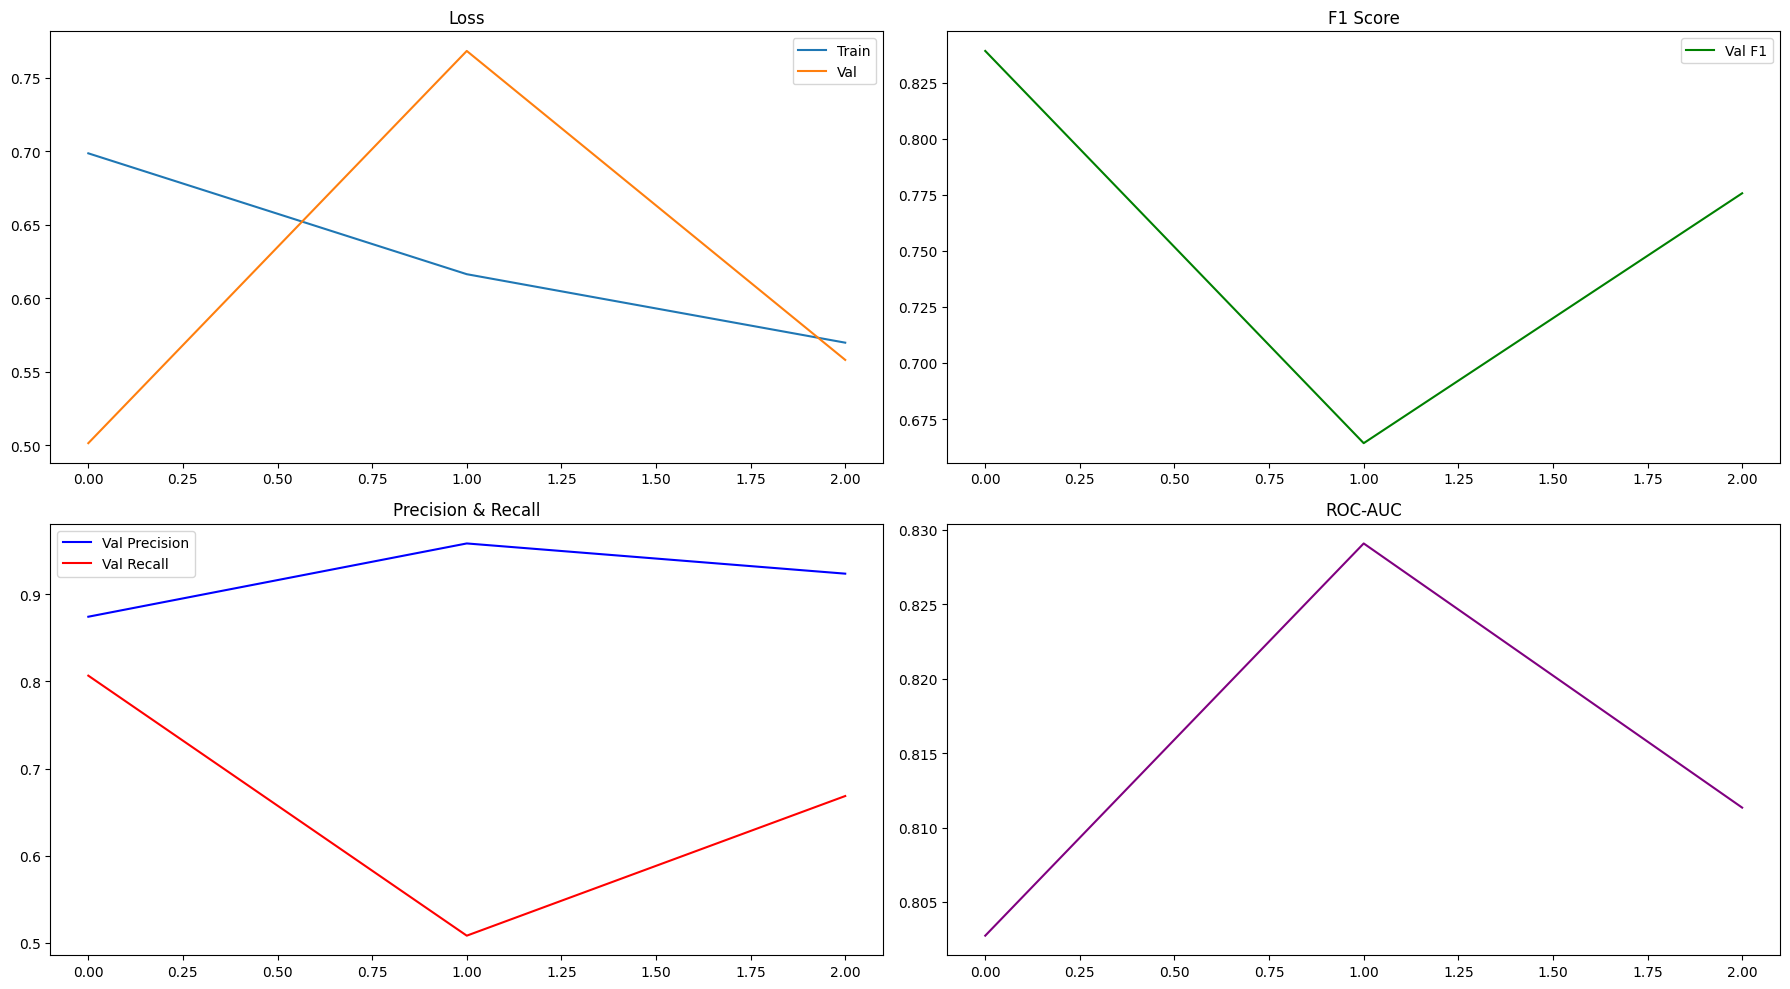

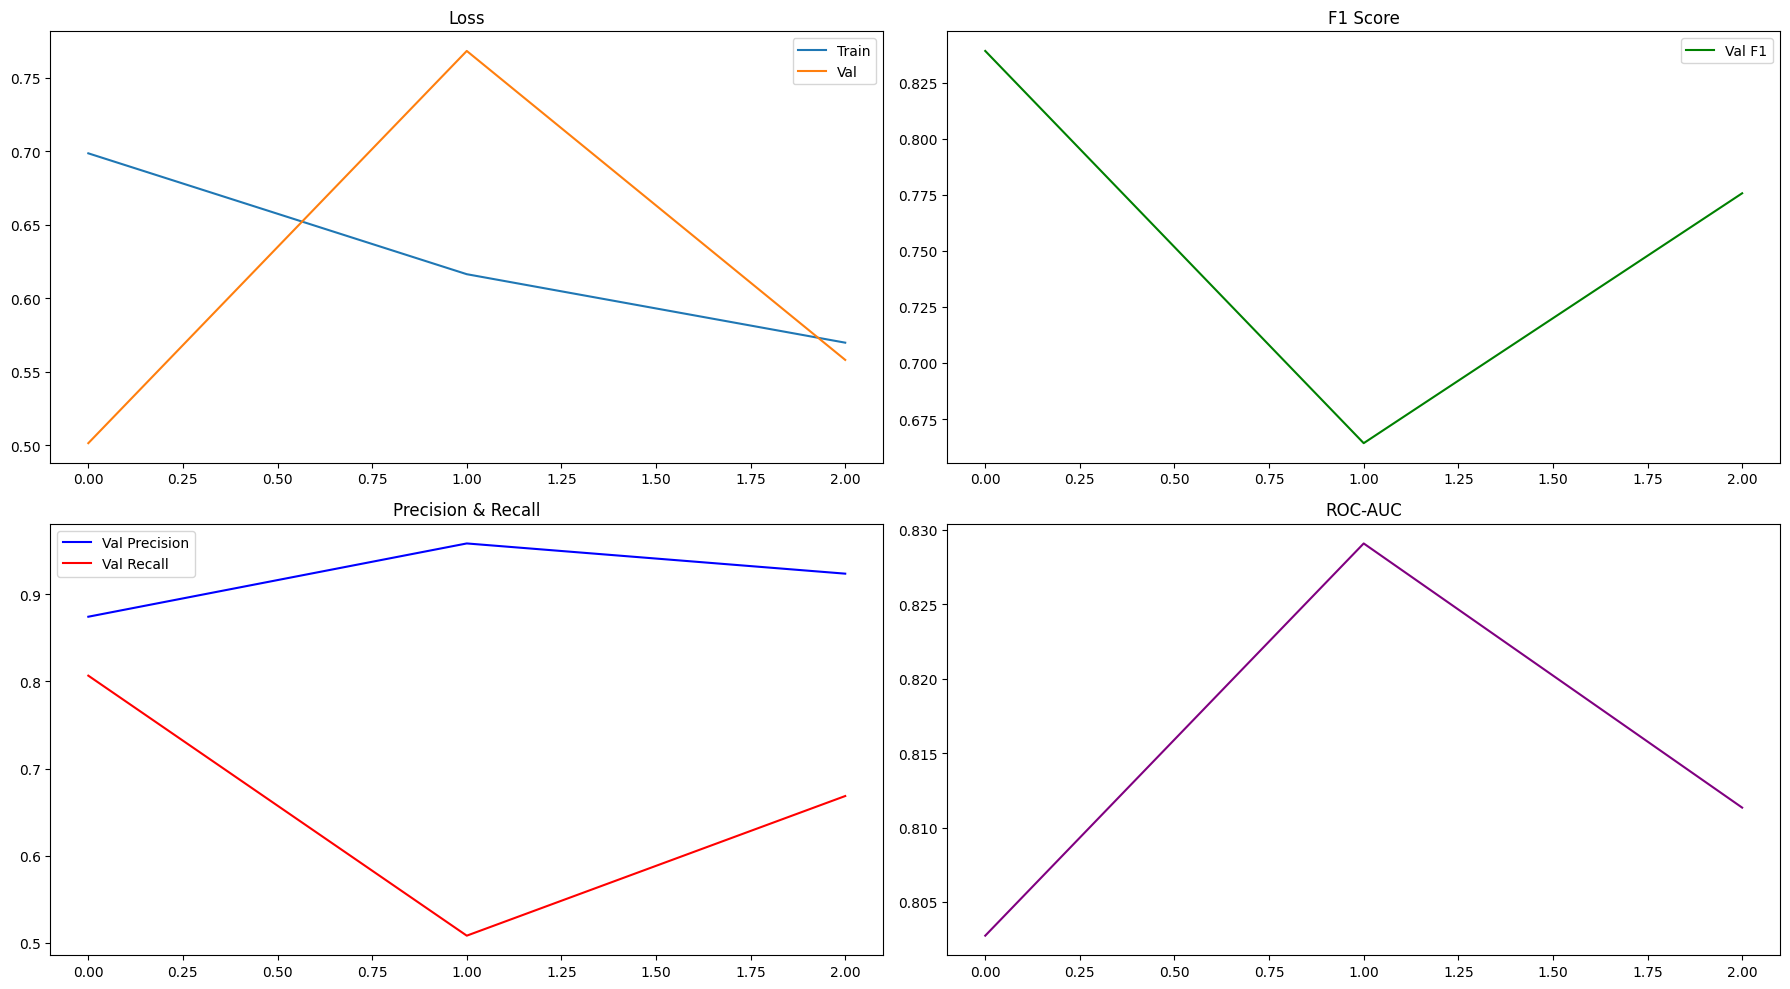

In [14]:
for param in scan_model.slice_encoder.parameters():
    param.requires_grad = False

pre_unfreeze_history = train_model(
    scan_model, 
    train_loader, 
    val_loader, 
    device, 
    epochs=pre_unfreeze_epochs, 
    lr=1e-4,
    wd=1e-5
)

plot_training_history(pre_unfreeze_history)

In [15]:
setup_fine_tuning_complete(scan_model, backbone_unfreeze_layers=3)

optimizer = create_complete_optimizer(scan_model)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

post_unfreeze_history = train_model(
    model=scan_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=post_unfreeze_epochs,
    optimizer=optimizer,
    scheduler=scheduler,
    save_path='best_stage2_model.pth'
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1
Train loss = 0.5220
Val metrics: loss = 0.4778, f1-score = 0.8563, precision = 0.8922, recall = 0.8232, ROC-AUC = 0.8246
Saved best model with F1 = 0.8563

Epoch 2
Train loss = 0.4871
Val metrics: loss = 0.6942, f1-score = 0.7475, precision = 0.9569, recall = 0.6133, ROC-AUC = 0.8417

Epoch 3
Train loss = 0.4506
Val metrics: loss = 0.5305, f1-score = 0.8297, precision = 0.9437, recall = 0.7403, ROC-AUC = 0.8460
Early stopping triggered after 2 epochs


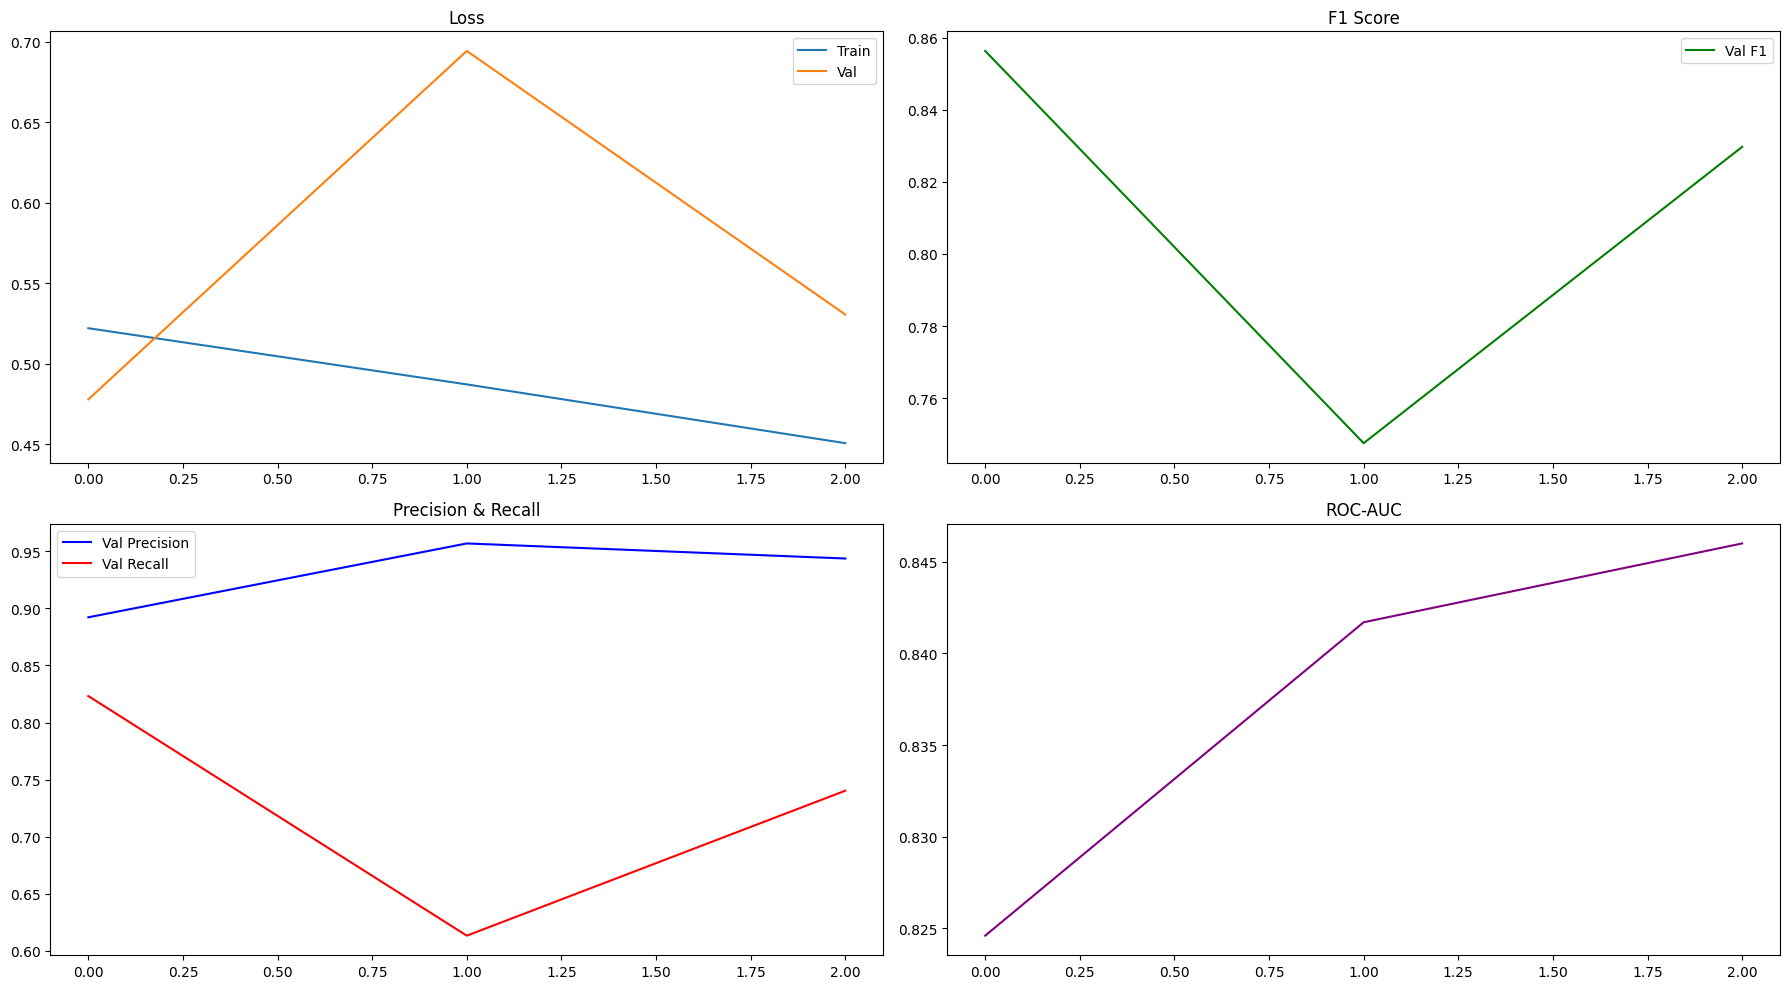

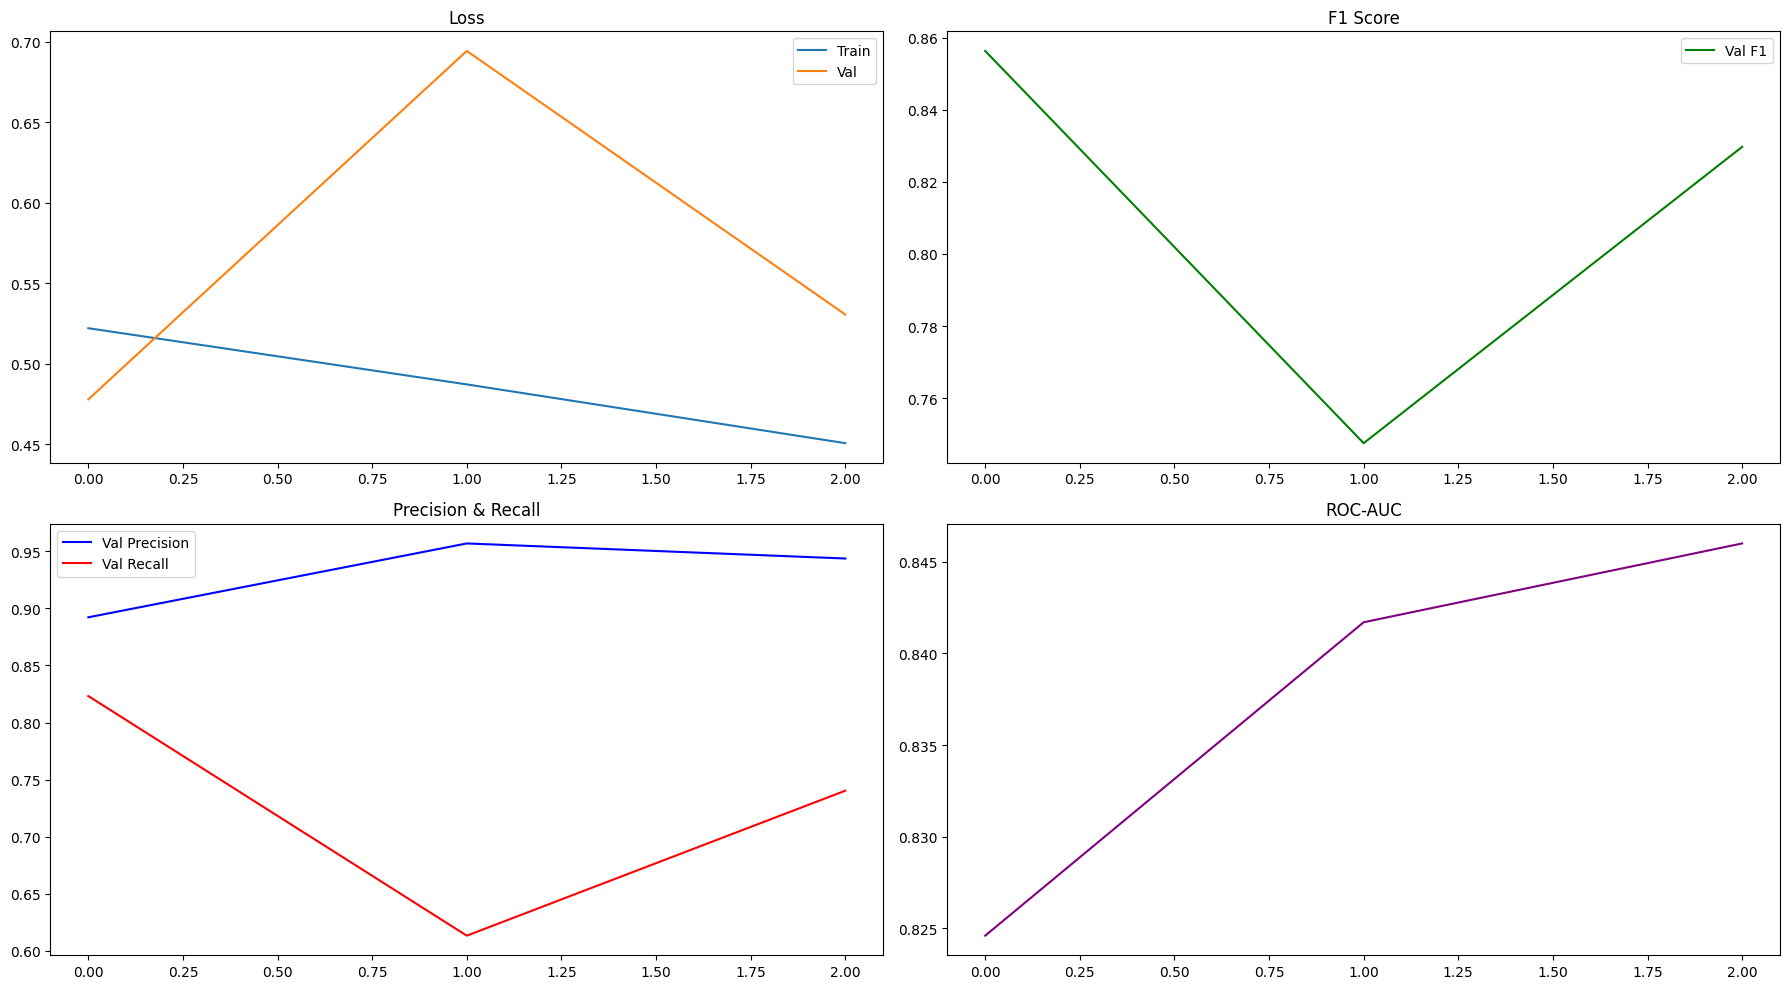

In [31]:
plot_training_history(post_unfreeze_history)

In [33]:
test_f1, test_precision, test_recall, test_roc_auc, _ = validate_model(scan_model, test_loader, device)

print("Test metrics:")
print(f"F1-score: {test_f1}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"ROC-AUC: {test_roc_auc}")

Test metrics:
F1-score: 0.8238636363636362
Precision: 0.847953216374269
Recall: 0.8011049723756906
ROC-AUC: 0.7701295172538719
